## I/O System Demo for  GeoidIO and SSHIO

### Import GeoidIO from gocean

In [1]:
import copy
from importlib import reload

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from gocean.io.geoid import GeoidIO

### Set the data directory for GeoidIO and read the .gdf file

In [2]:
# Set the data directory to GeoidIO
geoid = GeoidIO(data_dir='../../data')

# READ required file
geoid.read('geoid.gdf')

### Let's view the data and header for the geoid

In [3]:
# Required header elements
print('header: \n')
for key in geoid.header.keys():
    print(key, ': ', geoid.header[key])

header: 

lat_max :  22.78
lat_min :  5.18
long_min :  77.77
long_max :  98.67
latitude_parallels :  177
longitude_parallels :  210


In [4]:
# Geoid Data
print('Data: \n', geoid.data)


Data: 
         long    lat      geoid
0      77.77  22.78 -58.897233
1      77.87  22.78 -58.982584
2      77.97  22.78 -59.060798
3      78.07  22.78 -59.127344
4      78.17  22.78 -59.178009
...      ...    ...        ...
37165  98.27   5.18 -20.974614
37166  98.37   5.18 -20.494548
37167  98.47   5.18 -19.996221
37168  98.57   5.18 -19.483223
37169  98.67   5.18 -18.961050

[37170 rows x 3 columns]


### Create a Geoid grid and visualize

In [5]:
# Create geoid grid
geoid.create_geoid_grid()

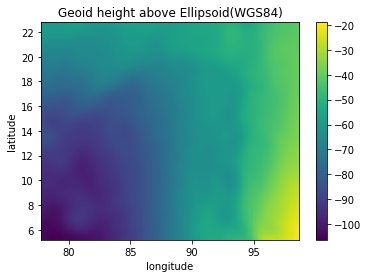

In [6]:
# Plot the geoid grid
plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])
# create the axis labels and metadat
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Geoid height above Ellipsoid(WGS84)')

# Create colorbar and save the figure
plt.colorbar()
plt.savefig('geoid.png')
plt.show()

### Import SSHIO from gocean

In [7]:
from gocean.io.altimetry import SSHIO

### Set the data directory for jason and saral data

In [8]:
# Create jason parsing utility
jason = SSHIO('../../data/altimetry')

### Read the SSH data and fill the similar grid as geoid

In [9]:
# Load the data and fill the grid
jason.read(geoid.grid, sigma=1.8)

### Visualize SSH from Jason and SARAL

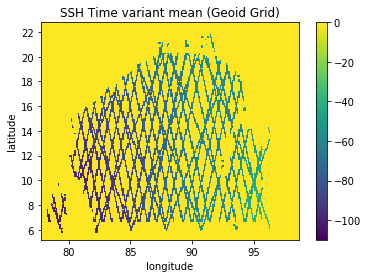

In [10]:
# plot the altimetry data points with temporal mean
plt.imshow(jason.grid[:, :, 1], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

# create axis label
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH Time variant mean (Geoid Grid)')

plt.colorbar()
# save the figure
plt.savefig('ssh-tvm.png')
plt.show()

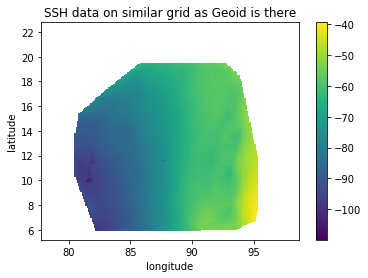

In [11]:
# plot the interpolated data grid
plt.imshow(jason.grid_filled[:, :], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

# Create the label
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH data on similar grid as Geoid is there')

plt.colorbar()
# save the figure
plt.savefig('ssh.png')
plt.show()

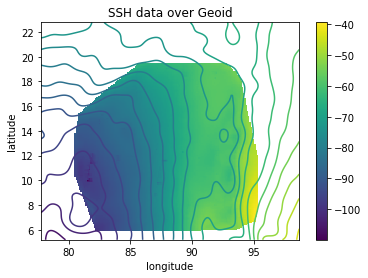

In [12]:
# Create the contour graph for geoid
plt.contour(geoid.grid[:, :, 1], geoid.grid[:, :, 0],
            geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']], levels=20)

# Create the altimetry grid
plt.imshow(jason.grid_filled[:, :], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

# Create the label
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH data over Geoid')

plt.colorbar()
# Save the figure
plt.savefig('ssh-geoid.png')
plt.show()


### Import mdt from gocean.currents module

In [13]:
from gocean.currents.mdt import mdt

In [14]:
# get the mdt
mdt_grid = mdt(geoid.grid[:, :, 2], jason.grid_filled)

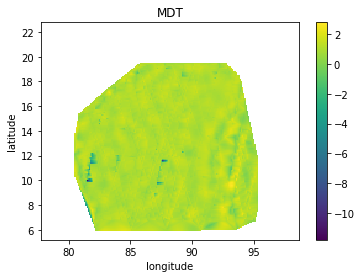

/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [15]:
# Show mdt grid
plt.imshow(mdt_grid, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
# Create the label
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT')

plt.colorbar()
# Save the figure
plt.savefig('mdt.png')
plt.show()

# jason.mask[np.where(mdt_grid<-2)] = True
# Threshold out the mdt
mdt_grid[np.where(mdt_grid<-2)] = -2

In [16]:
mdt_grid[jason.mask] = np.nan

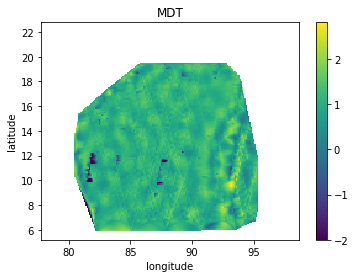

In [17]:
plt.imshow(mdt_grid, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT')

plt.colorbar()

plt.savefig('mdt_outl.png')
plt.show()

### Import filtering utility

In [18]:
from gocean.preprocessing.filters import gaussian

In [19]:
# prepare for filtering
mdt_final = copy.copy(mdt_grid)
mdt_final[jason.mask] = 0

In [20]:
# filter out the mdt for denoising & delining
mdt_filtered = gaussian(mdt_final, jason.mask, 1)

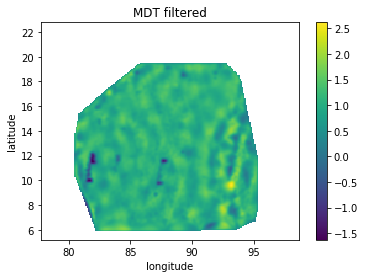

In [21]:
# Plot the filtered data
plt.imshow(mdt_filtered, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT filtered')

plt.colorbar()
# save the figure
plt.savefig('mdt-filtered.png')
plt.show()


### Now decompose the current components

In [22]:
from gocean.currents.current import decompose

In [23]:
# Decompose the current components
u, v = decompose(mdt_final, geoid.grid[:, :, :2])

### Histogram analysis of data

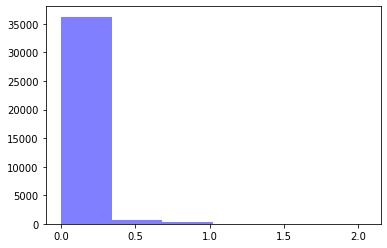

In [24]:
# Get the magnitude
mag = np.sqrt(u**2+v**2)
mag[np.where(mag < 1e-7)] = 1e-7

# Get the unit vector
u = u/mag
v = v/mag

# Plot histogram
num_bins = 6
n, bins, patches = plt.hist(mag.flatten(), num_bins, facecolor='blue', alpha=0.5)
plt.show()

### Update the mask and grid map

In [25]:
# Update mask
mag[np.where(mag > 0.6)] = 0.6

# Copy geoid grid
n_ggrid = np.copy(geoid.grid)
n_u = np.copy(u)
n_v = np.copy(v)
n_mask = np.copy(jason.mask)
n_mag = np.copy(mag)

In [26]:
# Crop down access area
rows, cols = np.where(jason.mask == False)

n_ggrid = n_ggrid[rows.min():rows.max(), cols.min():cols.max(), :]
n_u = n_u[rows.min():rows.max(), cols.min():cols.max()]
n_v = n_v[rows.min():rows.max(), cols.min():cols.max()]
n_mask = n_mask[rows.min():rows.max(), cols.min():cols.max()]
n_mag = n_mag[rows.min():rows.max(), cols.min():cols.max()]

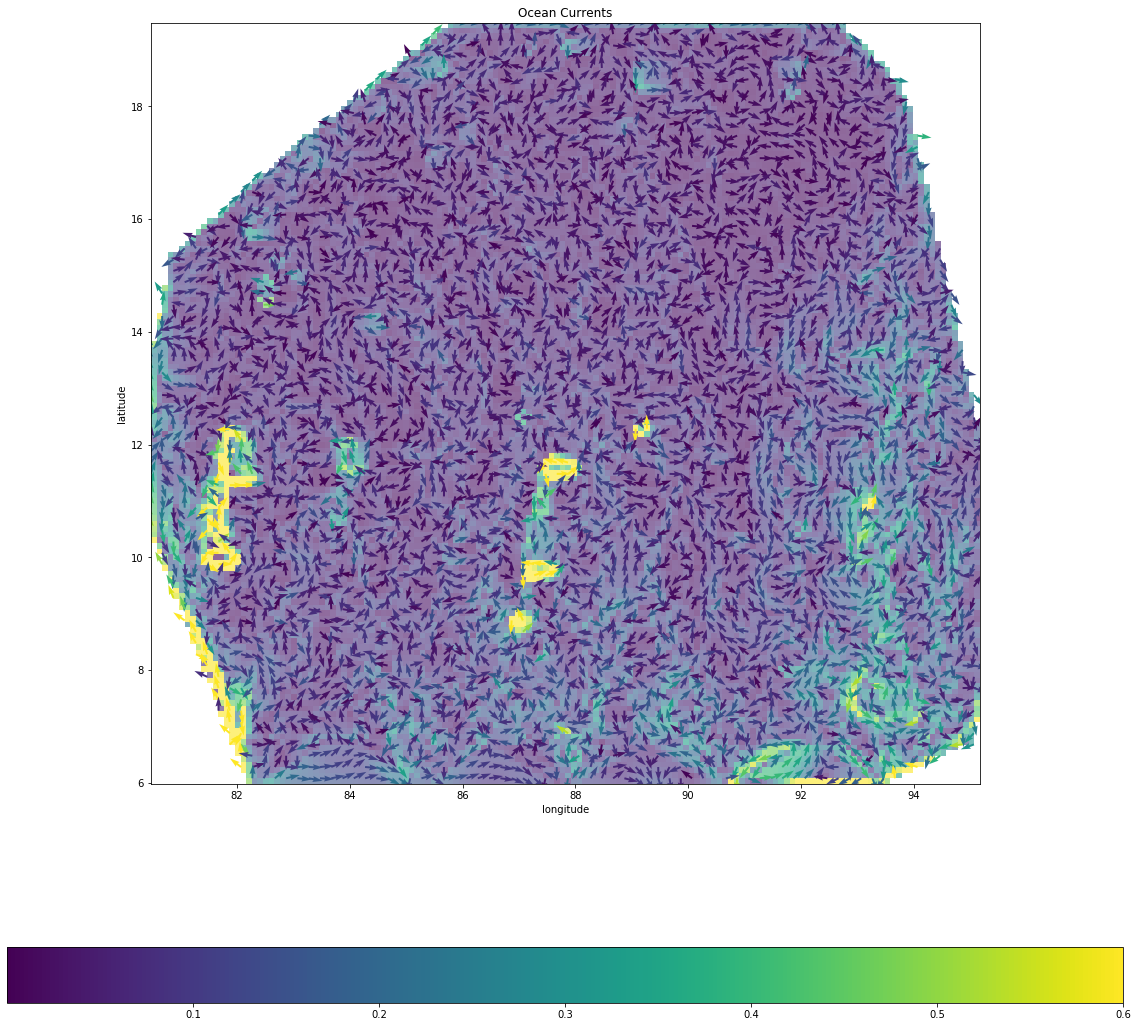

In [27]:
# get down the land area
n_u[n_mask] = np.nan
n_v[n_mask] = np.nan
n_mag[n_mask] = np.nan

# get the size of graph
w = 20
h = 20
fig = plt.figure(figsize=(w, h))

# sampling stride
ss = 2

# show the magnitude as background figure
plt.imshow(n_mag,
           extent=[n_ggrid[:, :, 1].min(),
                   n_ggrid[:, :, 1].max(),
                   n_ggrid[:, :, 0].min(),
                   n_ggrid[:, :, 0].max()], alpha=0.6)

# Show the direction
plt.quiver(n_ggrid[::ss, ::ss, 1],
           n_ggrid[::ss, ::ss, 0],
           n_v[::ss, ::ss],
           n_u[::ss, ::ss],
           n_mag[::ss, ::ss],
           scale=4, angles='xy', scale_units='xy')

# Graph metadata
plt.colorbar(orientation="horizontal")

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Ocean Currents')

# save figure
plt.savefig('currents-overall.png')
plt.show()

### Dense Current representation for continuous current view

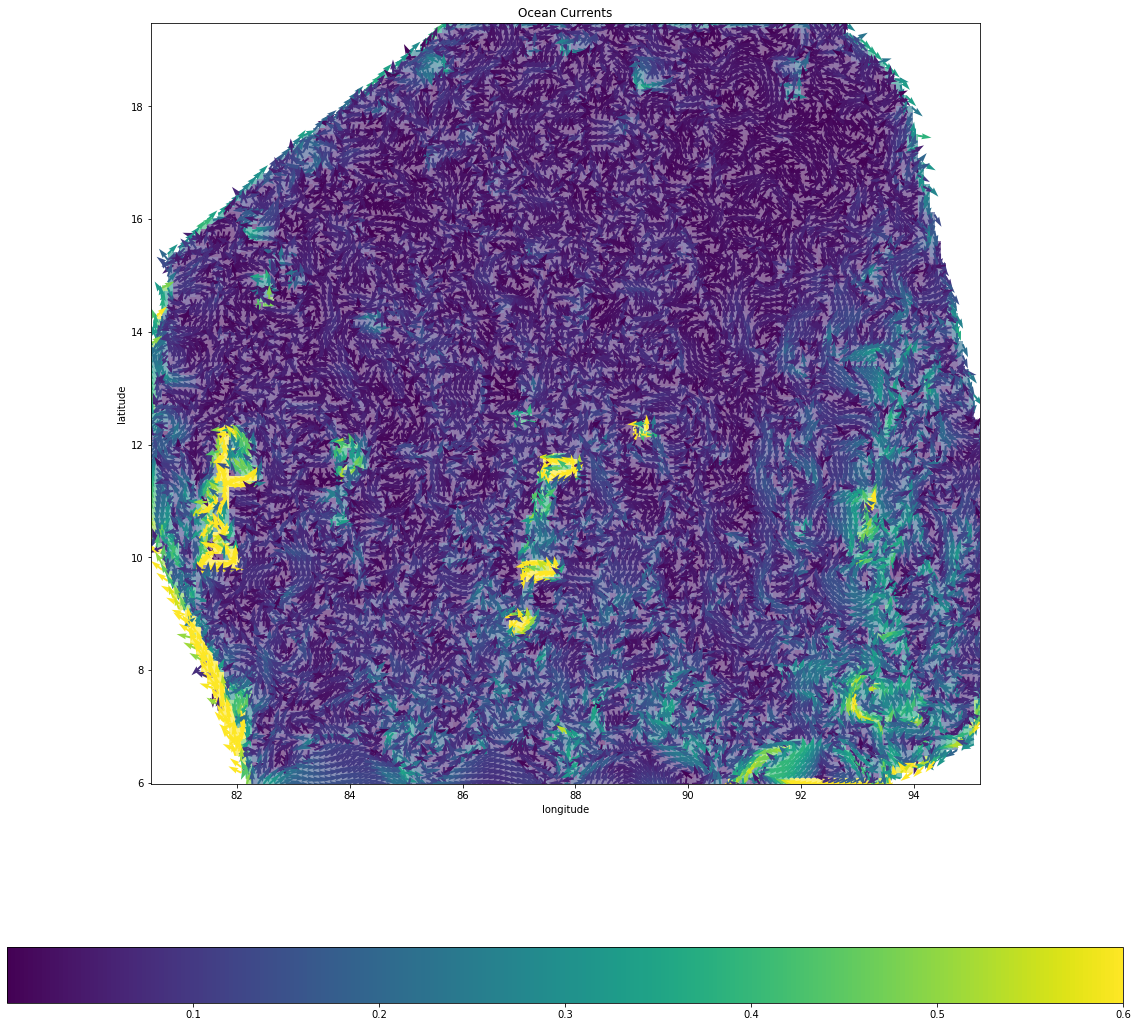

In [28]:

# n_u[n_mask] = np.nan
# n_v[n_mask] = np.nan

# get the size of graph
w = 20
h = 20
fig = plt.figure(figsize=(w, h))

# sampling rate
ss = 1

# show the magnitude as background figure
plt.imshow(n_mag,
           extent=[n_ggrid[:, :, 1].min(),
                   n_ggrid[:, :, 1].max(),
                   n_ggrid[:, :, 0].min(),
                   n_ggrid[:, :, 0].max()], alpha=0.6)

# Get the vectors
plt.quiver(n_ggrid[::ss, ::ss, 1],
           n_ggrid[::ss, ::ss, 0],
           n_v[::ss, ::ss],
           n_u[::ss, ::ss],
           n_mag[::ss, ::ss],
           scale=4, angles='xy', scale_units='xy')

plt.colorbar(orientation="horizontal")
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Ocean Currents')
# save the graph figure
plt.savefig('currents-overall1.png')
plt.show()

### Crop down to small area

In [29]:
# Save the graph as zoomed figure
for row in range(0, n_ggrid.shape[0], 50):
    for col in range(0, n_ggrid.shape[1], 50):
        n_ggrid_crop = np.copy(n_ggrid)
        n_u_crop = np.copy(n_u)
        n_v_crop = np.copy(n_v)
        n_mask_crop = np.copy(n_mask)
        n_mag_crop = np.copy(n_mag)

        # row = 70
        # col = 100

        n_ggrid_crop = n_ggrid_crop[row:row+50, col:col+50, :]
        n_u_crop = n_u_crop[row:row+50, col:col+50]
        n_v_crop = n_v_crop[row:row+50, col:col+50]
        n_mask_crop = n_mask_crop[row:row+50, col:col+50]
        n_mag_crop = n_mag_crop[row:row+50, col:col+50]

        w = 20
        h = 20
        fig = plt.figure(figsize=(w,h))

        ss = 1

        plt.imshow(n_mag_crop,
                   extent=[n_ggrid_crop[:, :, 1].min(),
                         n_ggrid_crop[:, :, 1].max(),
                         n_ggrid_crop[:, :, 0].min(),
                         n_ggrid_crop[:, :, 0].max()], alpha=0.6)

        plt.quiver(n_ggrid_crop[::ss, ::ss, 1],
                   n_ggrid_crop[::ss, ::ss, 0],
                   n_v_crop[::ss, ::ss],
                   n_u_crop[::ss, ::ss],
                   n_mag_crop[::ss, ::ss],
                   scale=8, angles='xy', scale_units='xy')

        plt.colorbar(orientation="horizontal")
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title('Ocean Currents')

        plt.savefig('currents/currents-overall-cropped-'+str(row)+'-'+str(col)+'.png')
        plt.close()
        # plt.show()

### Apply k-means clustering

In [38]:
# modeling
from sklearn.cluster import KMeans

In [30]:
curr = np.zeros([geoid.grid.shape[0], geoid.grid.shape[1], 3])
curr[:, :, 0] = mag
curr[:, :, 1] = v
curr[:, :, 2] = u

In [41]:
X = np.reshape(curr, newshape=[geoid.grid.shape[0]*geoid.grid.shape[1], 3])

kmeans = KMeans(n_clusters = 3,
                n_jobs = -1,
                random_state = 123).fit(X)
kmeans_df = pd.DataFrame(kmeans.cluster_centers_, columns = ['Magnitude', 'Longitude Direction', 'Latitude Direction'])

In [42]:
kmeans_df

,Magnitude,Longitude Direction,Latitude Direction
0,0.024392,-0.181484,0.056973
1,0.108785,0.121012,-0.826763
2,0.101371,0.548057,0.609355


In [43]:
import webcolors

In [44]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]
def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name
kmeans_df["Color Name"] = list(map(get_colour_name, np.uint8(kmeans.cluster_centers_[:, :3])))
kmeans_df

,Magnitude,Longitude Direction,Latitude Direction,Color Name
0,0.024392,-0.181484,0.056973,black
1,0.108785,0.121012,-0.826763,black
2,0.101371,0.548057,0.609355,black


In [45]:
def replaceWithCentroid(kmeans):
    new_pixels = []
    for label in kmeans.labels_:
        pixel_as_centroid = list(kmeans.cluster_centers_[label])
        new_pixels.append(pixel_as_centroid)
    new_pixels = np.array(new_pixels).reshape(geoid.grid.shape[0]*geoid.grid.shape[1], -1)
    return new_pixels
new_pixels = replaceWithCentroid(kmeans)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


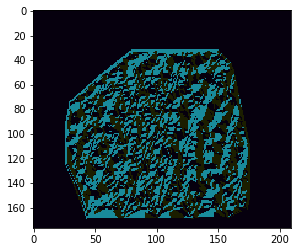

In [48]:
plt.imshow(new_pixels.reshape([geoid.grid.shape[0],
                                               geoid.grid.shape[1], 3]))
plt.savefig('k-means.png')
plt.show()